In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join, exists
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
from copy import deepcopy
from utils import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from scipy.optimize import least_squares
%matplotlib inline

This Python notebook analyzes the Bass model parameters that have been fitted. Based on the Bass model parameters, adoption phases (onset, ramp-up, ramp-down, saturation) have been derived for each block group. Intermediate results are also generated for regression analysis.

Figure 2 in the paper can be produced using this notebook.

In [2]:
%load_ext rpy2.ipython

In [3]:
def LocalRegression(X_input, y_input, bandwidth):
    """
    Local regression given an array of x value and an array of y value
    """
    X = np.reshape(np.array(X_input), [-1])
    y = np.reshape(np.array(y_input), [-1])
    X_norm = (X - X.min())/(X.max() - X.min())
    X_lin = np.linspace(0, 1, 100)
    y_pred = np.zeros([100])
    for i in range(100):
        x_i = X_lin[i]
        weights = np.exp(-np.square(x_i - X_norm)/(2*np.square(bandwidth)))
        LR = LinearRegression()
        LR.fit(X=X_norm.reshape(-1,1), y=y, sample_weight=weights)
        y_pred[i] = LR.predict([[x_i]])[0]
    X_out = X_lin * (X.max() - X.min()) + X.min()
    return X_out, y_pred

In [4]:
def make_str(depedent, features):
    """Generate the formula string given a dependent variable and a list of features"""
    assert features
    s = depedent + ' ~ ' + features[0]
    for f in features[1:]:
        s += ' + ' + f
    return s

In [5]:
def get_cum_installations(coefs, t):
    """Given Bass model coefficients, and a time array, return the array of cumulative values."""
    p, q, m, d = coefs
    y = (1 - np.exp(-(p + q) * (t - d))) / (1 + q / p * np.exp(-(p + q) * (t - d)))
    return m * y * (t >= d) + 0 * (t < d)

def get_residuals_cum(coefs, t, y_true):
    """
    Given Bass model coefficients, and a time array, return resididual between true cumulative
    values and predicted cumulative values (predicted by Bass model).
    """
    y_pred = get_cum_installations(coefs, t)
    return y_pred - y_true

In [6]:
def get_cum_installations_GBM(coefs, t):
    """
    Given Generalized Bass model coefficients, and a time array, return the array of 
    cumulative values.
    """
    p, q, m, d, beta = coefs
    y = (1 - np.exp(-(p + q) * (t - d + beta * log_price_trend))) / (1 + q / p * np.exp(-(p + q) * (t - d + beta * log_price_trend)))
    return m * y * (t >= d) + 0 * (t < d)

def get_residuals_cum_GBM(coefs, t, y_true):
    """
    Given Generalized Bass model coefficients, and a time array, return resididual between true
    cumulative values and predicted cumulative values (predicted by Bass model).
    """
    y_pred = get_cum_installations_GBM(coefs, t)
    return y_pred - y_true

In [7]:
def get_t_by_cum_adoption_rate(p, q, m, d, cum_adoption_rate):
    """
    Given a target cumulative rate value, return the time when that this target is reached.
    """
    k = (1 - cum_adoption_rate) / (1 + q/p * cum_adoption_rate)
    t = - np.log(k) / (p + q)
    return t + d

def get_t_by_cum_adoption_amount(p, q, m, d, amount):
    """
    Given a target cumulative amount value, return the time when that this target is reached.
    """
    cum_adoption_rate = np.minimum(amount / m, 0.999999)
    return get_t_by_cum_adoption_rate(p, q, m, d, cum_adoption_rate)

# 1. Load data

In [9]:
bg = pd.read_csv('results/merged_bg.csv')
bg['tract_FIPS'] = bg['blockgroup_FIPS'] // 10
bg['county_FIPS'] = bg['blockgroup_FIPS'] // 10000000
bg['state_FIPS'] = bg['blockgroup_FIPS'] // 10000000000

In [10]:
df = bg.sort_values(['year', 'blockgroup_FIPS'])

In [11]:
# Calculate cumulative PV installations in each year
cumulative_pv_count_dict = {}
cumulative_pv_count = np.array(df[df['year'] == 2005]['num_of_installations'])
cumulative_pv_count_dict[2005] = cumulative_pv_count.copy()
for year in range(2006, 2018):
    cumulative_pv_count = cumulative_pv_count + np.array(df[df['year'] == year]['num_of_installations'])
    cumulative_pv_count_dict[year] = cumulative_pv_count.copy()

In [ ]:
del bg

In [14]:
df['cum_num_of_installations'] = np.concatenate([cumulative_pv_count_dict[x] for x in cumulative_pv_count_dict])
df.sort_values(['blockgroup_FIPS', 'year'], inplace=True)

In [15]:
# Create static ACS variables
ACS_cols = [x for x in df.columns if x[:3] == 'ACS']
ACS2016_sub = df[df['year'] == 2016][['blockgroup_FIPS'] + ACS_cols]
rename_dict_ACS = {x: x + '_2016' for x in ACS_cols}
ACS2016_sub.rename(columns=rename_dict_ACS, inplace=True)
df = pd.merge(df, ACS2016_sub, how='left', on='blockgroup_FIPS')

In [16]:
# Calculate the cumulative installations in previous year
prev_year_cum = df[(df['year'] <= 2015) & (df['year'] >= 2005)][['blockgroup_FIPS', 
                                                                 'year',
                                                                 'cum_num_of_installations']]
# prev_year_cum.index = prev_year_cum['blockgroup_FIPS']
prev_year_cum.rename(columns={'cum_num_of_installations': 'cum_num_of_installations_prev'}, inplace=True)
prev_year_cum['year'] = prev_year_cum['year'] + 1

In [17]:
df_sub = df[(df['year'] <= 2016) & (df['year'] >= 2006)]

In [18]:
df_sub = pd.merge(df_sub, prev_year_cum, how='left', on=['blockgroup_FIPS', 'year'])

In [19]:
# number of installations in each year
adoption_matrix_bg = pd.DataFrame(df_sub['num_of_installations'].to_numpy().reshape([-1, 11]))
adoption_matrix_bg.index = df_sub[df_sub['year'] == 2016]['blockgroup_FIPS']
adoption_matrix_bg.columns = [str(x) for x in range(2006, 2017)]
# cumulative number of installations till previous year
cum_adoption_matrix_prev_bg = pd.DataFrame(df_sub['cum_num_of_installations_prev'].to_numpy().reshape([-1, 11]))
cum_adoption_matrix_prev_bg.index = df_sub[df_sub['year'] == 2016]['blockgroup_FIPS']
cum_adoption_matrix_prev_bg.columns = [str(x) for x in range(2006, 2017)]
# cumulative number of installations till each year
cum_adoption_matrix_bg = pd.DataFrame(df[df['year'] <= 2016]['cum_num_of_installations'].to_numpy().reshape([-1, 12]))
cum_adoption_matrix_bg.index = df[df['year'] == 2016]['blockgroup_FIPS']
cum_adoption_matrix_bg.columns = [str(x) for x in range(2005, 2017)]

In [21]:
# Block groups where there are at least 2 years with new adoption
not_step_func_adoption_bgs = adoption_matrix_bg[np.sum(adoption_matrix_bg > 0, axis=1) > 1].index
# Block groups where there is only 1 year with new adoption
step_func_adoption_bgs = adoption_matrix_bg[np.sum(adoption_matrix_bg > 0, axis=1) == 1].index

## 1.1 Load Bass model fitted results

In [27]:
adoption_params_bg = pd.read_csv('results/bass_model/adoption_bass_model_params_bg.csv')
adoption_params_bg.rename(columns={'Unnamed: 0': 'blockgroup_FIPS'}, inplace=True)
# adoption_params_bg.index = adoption_params_bg['blockgroup_FIPS']

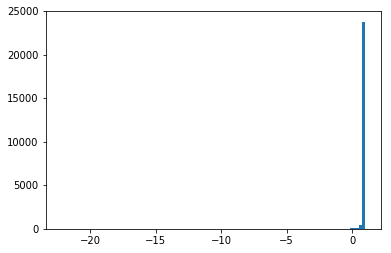

In [28]:
adoption_params_bg_sub = adoption_params_bg[adoption_params_bg['d'].isnull() == False]
_ = plt.hist(adoption_params_bg_sub['r2'], bins=100)
# _ = plt.xlim(-0.01, 0.2)
# plt.ylim(0, 1000)

In [29]:
print(adoption_params_bg_sub['r2'].quantile(0.1), adoption_params_bg_sub['r2'].quantile(0.9))
print(adoption_params_bg_sub['r2'].median())

0.9090682841230259 1.0
0.9858378249089916


In [31]:
# Create a data frame for covariates
selected_covariates = [x for x in df.columns if 'ACS' in x and '2016' in x]
selected_covariates.extend(['residential_rate_inflation_adj', 
                            'avg_GHI', 
                            'sunroof_percent_qualified',
                            'num_of_buildings_lt600',
                            'blockgroup_FIPS'
                           ])
covariate_df = df[df['year'] == 2016][selected_covariates]
# covariate_df.index = covariate_df['blockgroup_FIPS'] 

In [32]:
merged = pd.merge(adoption_params_bg, covariate_df, how='left', on='blockgroup_FIPS')

In [33]:
# derived variables
merged['saturated_adoption_rate'] = merged['m'] / merged['ACS_household_count_2016']
merged['saturated_adoption_rate'] = merged['saturated_adoption_rate'].replace(np.nan, 0.)
merged['saturated_adoption_rate'] = np.minimum(merged['saturated_adoption_rate'], 1.0)

merged['saturated_adoption_rate_housing_unit'] = merged['m'] / merged['ACS_housing_unit_count_2016']
merged['saturated_adoption_rate_housing_unit'] = merged['saturated_adoption_rate_housing_unit'].replace(np.nan, 0.)
merged['saturated_adoption_rate_housing_unit'] = np.minimum(merged['saturated_adoption_rate_housing_unit'], 1.0)

merged['saturated_adoption_rate_building_lt600'] = merged['m'] / merged['num_of_buildings_lt600']
merged['saturated_adoption_rate_building_lt600'] = merged['saturated_adoption_rate_building_lt600'].replace(np.nan, 0.)
merged['saturated_adoption_rate_building_lt600'] = np.minimum(merged['saturated_adoption_rate_building_lt600'], 1.0)

merged['normalized_p'] = merged['saturated_adoption_rate'] * merged['p']
merged['normalized_q'] = merged['saturated_adoption_rate'] * merged['q']
merged['normalized_d'] = np.maximum(merged['d'], 0)

merged['state_FIPS'] = merged['blockgroup_FIPS'] // 10000000000
merged['state_FIPS'] = merged['state_FIPS'].astype(str)

merged['peak_time'] = np.log(merged['q'] / merged['p']) / (merged['q'] + merged['p']) + merged['d']
merged['saturation_time_0.95'] = get_t_by_cum_adoption_rate(merged['p'], merged['q'], merged['m'], merged['d'], 0.95)
merged['saturation_time_0.8'] = get_t_by_cum_adoption_rate(merged['p'], merged['q'], merged['m'], merged['d'], 0.8)
merged['saturation_time_0.9'] = get_t_by_cum_adoption_rate(merged['p'], merged['q'], merged['m'], merged['d'], 0.9)

merged['saturation_time_0.95_normalized'] = \
        get_t_by_cum_adoption_amount(merged['p'], merged['q'], merged['m'], merged['d'], 
                    0.95 * merged['saturated_adoption_rate_building_lt600'] * merged['num_of_buildings_lt600'])

# The year when 1st PV was installed in a blockgroup, predicted by fitted Bass model
merged['predicted_1st_adoption_time'] = \
        get_t_by_cum_adoption_amount(merged['p'], merged['q'], merged['m'], merged['d'], 1)

In [34]:
# The year when 1st PV was installed in a blockgroup, observed in the data
l = []
for i in merged.index:
    bfips = merged.loc[i, 'blockgroup_FIPS']
    first_year = None
    for year in range(2005, 2017):
        if cum_adoption_matrix_bg.loc[bfips, str(year)] > 0:
            first_year = year
            break
    l.append(first_year)
merged['actual_1st_adoption_time'] = l
merged['actual_1st_adoption_time'] -= 2006

## 1.2 Load incentive data

In [57]:
incentive_type_indicator_df = pd.read_csv('data/incentives/incentive_type_indicators.csv')
incentive_type_first_intro_year_df = pd.read_csv('data/incentives/incentive_type_first_intro_years.csv')
incentive_type_indicator_at_onset_df = pd.read_csv('data/incentives/incentive_type_indicators_at_onset.csv')
incentive_type_indicator_before_saturation_df = pd.read_csv(
    'data/incentives/incentive_type_indicators_before_saturation.csv')
incentive_type_first_intro_year_before_onset_df = pd.read_csv(
    'data/incentives/incentive_type_first_intro_years_before_saturation.csv')

In [58]:
merged2 = pd.merge(merged, incentive_type_indicator_df, how='left', on='blockgroup_FIPS')
merged2 = pd.merge(merged2, incentive_type_first_intro_year_df, how='left', on='blockgroup_FIPS')
# extra
merged2 = pd.merge(merged2, incentive_type_indicator_at_onset_df, how='left', on='blockgroup_FIPS')
merged2 = pd.merge(merged2, incentive_type_indicator_before_saturation_df, how='left', on='blockgroup_FIPS')
merged2 = pd.merge(merged2, incentive_type_first_intro_year_before_onset_df, how='left', on='blockgroup_FIPS')

In [59]:
merged2['is_step_func_curve'] = merged2['blockgroup_FIPS'].isin(step_func_adoption_bgs).astype(int)

## 1.3 Income and racial group

In [61]:
income_group_df = pd.read_csv('data/socioeconomics/bg_income_racial_group_420counties_v1.csv')
# income_group_df['blockgroup_FIPS'] = income_group_df['blockgroup_FIPS'].astype(str)

In [65]:
merged3 = pd.merge(merged2, income_group_df, how='left', on='blockgroup_FIPS')

In [66]:
merged3['adoption_time_interval'] = merged3['saturation_time_0.95_normalized'] - merged3['d']

In [68]:
# save intermediate dataframe for regression
merged3.to_csv('results/bass_model/merged_bg_bass.csv', index=False)

# 2. Four-phase segmentation

In [69]:
merged_sub = merged3[merged3['d'].isnull() == False]
year_list = list(range(2006, 2021))
x1_list = []
x2_list = []
x3_list = []
x4_list = []
for year in year_list:
    year_idx = year - 2006
    x1 = merged3['d'].isnull().sum()
    x1 += np.sum(year_idx < merged_sub['d'])
    x2 = np.sum((year_idx >= merged_sub['d']) & (year_idx < merged_sub['peak_time']))
    x3 = np.sum((year_idx >= merged_sub['d']) & (year_idx >= merged_sub['peak_time']) &\
                (year_idx < merged_sub['saturation_time_0.95']))
    x4 = np.sum(year_idx >= merged_sub['saturation_time_0.95'])
#     print(year, (x1, x2, x3, x4), x1+x2+x3+x4)
    x1_list.append(x1)
    x2_list.append(x2)
    x3_list.append(x3)
    x4_list.append(x4)
x1_list = np.array(x1_list) * 1. / merged.shape[0]
x2_list = np.array(x2_list) * 1. / merged.shape[0]
x3_list = np.array(x3_list) * 1. / merged.shape[0]
x4_list = np.array(x4_list) * 1. / merged.shape[0]

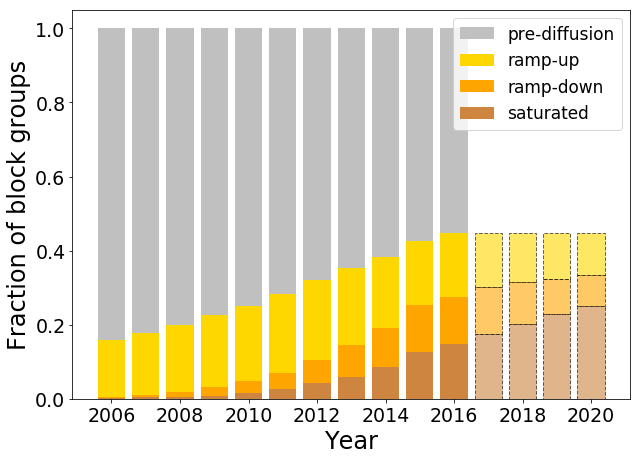

In [70]:
plt.figure(figsize=(9, 6.5))
hatch = None
ls = '--'
edgecolor = 'black'
alpha = 0.6
plt.bar(year_list[:-4], x1_list[:-4], width=0.8, color='silver', bottom=x2_list[:-4]+x3_list[:-4]+x4_list[:-4], 
        label='pre-diffusion')
plt.bar(year_list[:-4], x2_list[:-4], width=0.8, color='gold', bottom=x3_list[:-4]+x4_list[:-4], 
        label='ramp-up')
plt.bar(year_list[:-4], x3_list[:-4], width=0.8, color='orange', bottom=x4_list[:-4], label='ramp-down')
plt.bar(year_list[:-4], x4_list[:-4], width=0.8, color='#CD853F', label='saturated')

plt.bar(year_list[-4:], x2_list[-4:], width=0.8, color='gold', bottom=x3_list[-4:]+x4_list[-4:], 
        linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
plt.bar(year_list[-4:], x3_list[-4:], width=0.8, color='orange', bottom=x4_list[-4:], 
        linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
plt.bar(year_list[-4:], x4_list[-4:], width=0.8, color='#CD853F', 
        linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Fraction of block groups', fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend(fontsize=17)
plt.tight_layout()

In [71]:
segments_by_income_level = {}
saturated_adoption_level_dist_list = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    df_sub = merged3[merged3[group] == 1]
    merged_sub = df_sub[df_sub['d'].isnull() == False]
    year_list = list(range(2006, 2021))
    x1_list = []
    x2_list = []
    x3_list = []
    x4_list = []
    saturated_adoption_level_by_year_list = []
    for year in year_list:
        year_idx = year - 2006
        x1 = df_sub['d'].isnull().sum()
        x1 += np.sum(year_idx < merged_sub['d'])
        x2 = np.sum((year_idx >= merged_sub['d']) & (year_idx < merged_sub['peak_time']))
        x3 = np.sum((year_idx >= merged_sub['d']) & (year_idx >= merged_sub['peak_time']) &\
                    (year_idx < merged_sub['saturation_time_0.95']))
        x4 = np.sum(year_idx >= merged_sub['saturation_time_0.95'])
        saturated_adoption_level = merged_sub[year_idx >= merged_sub['saturation_time_0.95']][
                                                            'saturated_adoption_rate_building_lt600'].median()
    #     print(year, (x1, x2, x3, x4), x1+x2+x3+x4)
        x1_list.append(x1)
        x2_list.append(x2)
        x3_list.append(x3)
        x4_list.append(x4)
        saturated_adoption_level_by_year_list.append(saturated_adoption_level)
    x1_list = np.array(x1_list) * 1. / df_sub.shape[0]
    x2_list = np.array(x2_list) * 1. / df_sub.shape[0]
    x3_list = np.array(x3_list) * 1. / df_sub.shape[0]
    x4_list = np.array(x4_list) * 1. / df_sub.shape[0]
    
    print(group, merged_sub[merged_sub['d'].isnull() == False]['saturated_adoption_rate_building_lt600'].median())
    saturated_adoption_level_dist_list[group] =\
                    merged_sub[merged_sub['d'].isnull() == False]['saturated_adoption_rate_building_lt600'].tolist()
    segments_by_income_level[group] = [x1_list, x2_list, x3_list, x4_list, saturated_adoption_level_by_year_list]

low_income_group 0.027929753493913155
midlow_income_group 0.037230874780580146
midhigh_income_group 0.050006817147371124
high_income_group 0.05822157359478841


In [72]:
for group in saturated_adoption_level_dist_list:
    print(np.median(saturated_adoption_level_dist_list[group]))

0.027929753493913155
0.037230874780580146
0.050006817147371124
0.05822157359478841


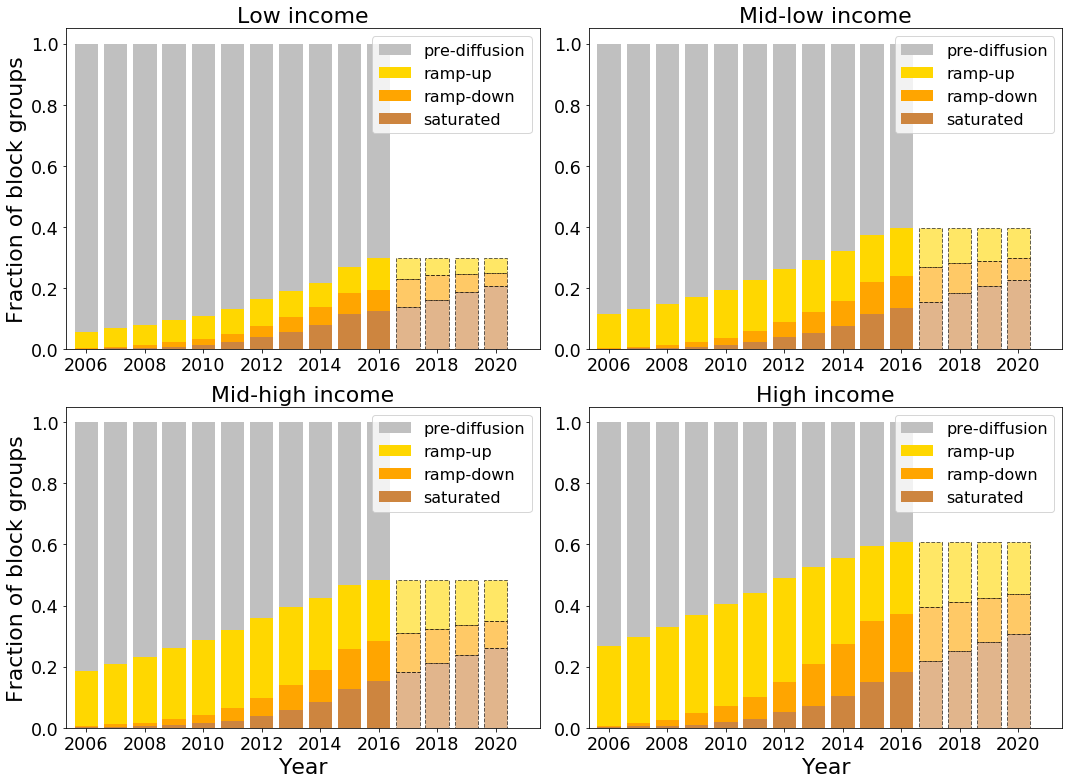

In [73]:
hatch = None
ls = '--'
edgecolor = 'black'
alpha = 0.6
title_list = ['Low income', 'Mid-low income', 'Mid-high income', 'High income']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    x1_list, x2_list, x3_list, x4_list, _ = segments_by_income_level[group]
    axes[i // 2, i % 2].bar(year_list[:-4], x1_list[:-4], width=0.8, color='silver', 
                            bottom=x2_list[:-4]+x3_list[:-4]+x4_list[:-4], label='pre-diffusion')
    axes[i // 2, i % 2].bar(year_list[:-4], x2_list[:-4], width=0.8, color='gold', 
                            bottom=x3_list[:-4]+x4_list[:-4], label='ramp-up')
    axes[i // 2, i % 2].bar(year_list[:-4], x3_list[:-4], width=0.8, color='orange', 
                            bottom=x4_list[:-4], label='ramp-down')
    axes[i // 2, i % 2].bar(year_list[:-4], x4_list[:-4], width=0.8, color='#CD853F', label='saturated')

    axes[i // 2, i % 2].bar(year_list[-4:], x2_list[-4:], width=0.8, color='gold', 
                            bottom=x3_list[-4:]+x4_list[-4:], 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    axes[i // 2, i % 2].bar(year_list[-4:], x3_list[-4:], width=0.8, color='orange', bottom=x4_list[-4:], 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    axes[i // 2, i % 2].bar(year_list[-4:], x4_list[-4:], width=0.8, color='#CD853F', 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    if i == 0 or i == 2:
        axes[i // 2, i % 2].set_ylabel('Fraction of block groups', fontsize=22)
    if i == 2 or i == 3:
        axes[i // 2, i % 2].set_xlabel('Year', fontsize=22)
    axes[i // 2, i % 2].tick_params(axis='both', which='major', labelsize=17.5)
    axes[i // 2, i % 2].set_title(title_list[i], fontsize=22)
    axes[i // 2, i % 2].legend(fontsize=16)
    axes[i // 2, i % 2].set_xlim(2005.3, 2021.5)
plt.tight_layout()

In [74]:
# Exclude pre-diffusion phase
segments_by_income_level = {}
for group in ['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']:
    df_sub = merged3[merged3[group] == 1]
    merged_sub = df_sub[df_sub['d'].isnull() == False]
    year_list = list(range(2006, 2021))
    x1_list = []
    x2_list = []
    x3_list = []
    x4_list = []
    for year in year_list:
        year_idx = year - 2006
        x1 = df_sub['d'].isnull().sum()
        x1 += np.sum(year_idx < merged_sub['d'])
        x2 = np.sum((year_idx >= merged_sub['d']) & (year_idx < merged_sub['peak_time']))
        x3 = np.sum((year_idx >= merged_sub['d']) & (year_idx >= merged_sub['peak_time']) &\
                    (year_idx < merged_sub['saturation_time_0.95']))
        x4 = np.sum(year_idx >= merged_sub['saturation_time_0.95'])
    #     print(year, (x1, x2, x3, x4), x1+x2+x3+x4)
#         x1_list.append(x1)
        x2_list.append(x2)
        x3_list.append(x3)
        x4_list.append(x4)
#     x1_list = np.array(x1_list) * 1. / df_sub.shape[0]
    denominator = np.array(x2_list) + np.array(x3_list) + np.array(x4_list)
    x2_list = np.array(x2_list) * 1. / denominator
    x3_list = np.array(x3_list) * 1. / denominator
    x4_list = np.array(x4_list) * 1. / denominator
    segments_by_income_level[group] = [x2_list, x3_list, x4_list]

In [75]:
for group in segments_by_income_level:
    print(group, segments_by_income_level[group][2][-1])

low_income_group 0.6873689727463312
midlow_income_group 0.5763903245813521
midhigh_income_group 0.5367647058823529
high_income_group 0.506029477445288


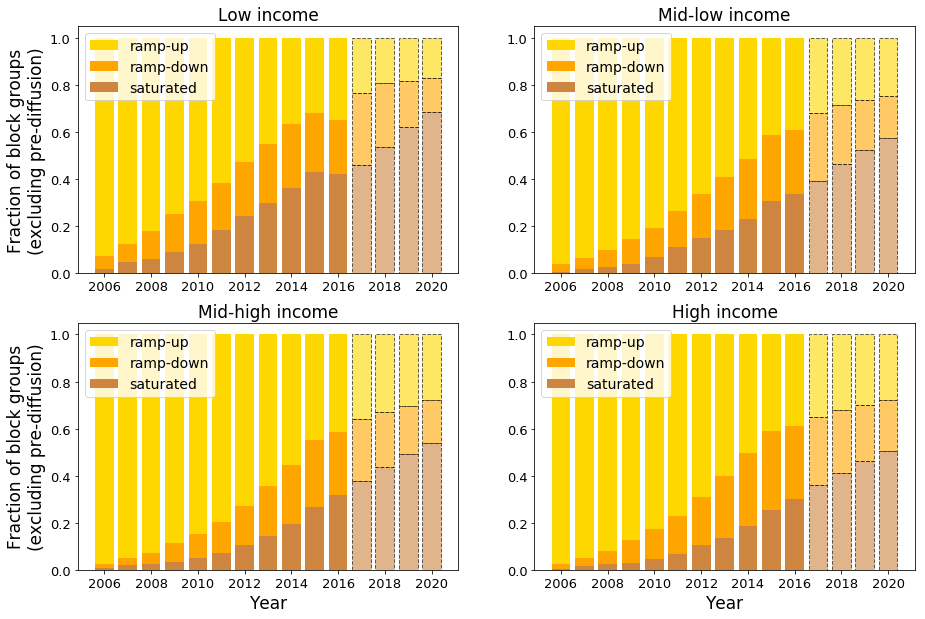

In [76]:
hatch = None
ls = '--'
edgecolor = 'black'
alpha = 0.6
title_list = ['Low income', 'Mid-low income', 'Mid-high income', 'High income']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, group in enumerate(['low_income_group', 'midlow_income_group', 'midhigh_income_group', 'high_income_group']):
    x2_list, x3_list, x4_list = segments_by_income_level[group]

    axes[i // 2, i % 2].bar(year_list[:-4], x2_list[:-4], width=0.8, color='gold', 
                            bottom=x3_list[:-4]+x4_list[:-4], label='ramp-up')
    axes[i // 2, i % 2].bar(year_list[:-4], x3_list[:-4], width=0.8, color='orange', 
                            bottom=x4_list[:-4], label='ramp-down')
    axes[i // 2, i % 2].bar(year_list[:-4], x4_list[:-4], width=0.8, color='#CD853F', label='saturated')

    axes[i // 2, i % 2].bar(year_list[-4:], x2_list[-4:], width=0.8, color='gold', 
                            bottom=x3_list[-4:]+x4_list[-4:], 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    axes[i // 2, i % 2].bar(year_list[-4:], x3_list[-4:], width=0.8, color='orange', bottom=x4_list[-4:], 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    axes[i // 2, i % 2].bar(year_list[-4:], x4_list[-4:], width=0.8, color='#CD853F', 
                            linestyle=ls, hatch=hatch, edgecolor=edgecolor, alpha=alpha)
    if i == 0 or i == 2:
        axes[i // 2, i % 2].set_ylabel('Fraction of block groups\n(excluding pre-diffusion)', fontsize=17)
    if i == 2 or i == 3:
        axes[i // 2, i % 2].set_xlabel('Year', fontsize=17)
    axes[i // 2, i % 2].tick_params(axis='both', which='major', labelsize=13)
    axes[i // 2, i % 2].set_title(title_list[i], fontsize=17)
    axes[i // 2, i % 2].legend(fontsize=14, loc=2)
    